### Classificação de textos para análise de sentimentos

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 26-06-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

Tutorial seguido: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

In [1]:
!which pip

/Users/leonardofiedler/Desenvolvimento/deep-learning/.venv/bin/pip


Carregamento das bibliotecas

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext import datasets
from string import punctuation
from torch.utils.data import DataLoader, TensorDataset

Carregamengo do dataset

In [3]:
train_iter, test_iter = datasets.IMDB()

Conversão para tipagem do Pandas

In [4]:
df_train = pd.DataFrame(train_iter, columns=['target','value'])

In [5]:
df_test = pd.DataFrame(test_iter, columns=['target','value'])
df_test.head()

,target,value
0,neg,I love sci-fi and am willing to put up with a ...
1,neg,"Worth the entertainment value of a rental, esp..."
2,neg,its a totally average film with a few semi-alr...
3,neg,STAR RATING: ***** Saturday Night **** Friday ...
4,neg,"First off let me say, If you haven't enjoyed a..."


Une ambos os dataset's em um único

In [6]:
df_data = df_train.append(df_test)

df_data.head()

,target,value
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


Plotagem de distribuição dos dados

In [7]:
df_data.target.value_counts()

neg    25000
pos    25000
Name: target, dtype: int64

<AxesSubplot:>

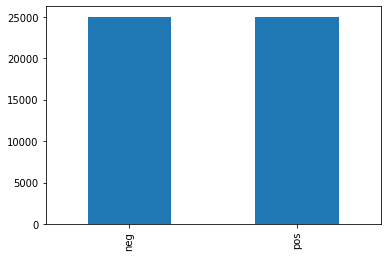

In [8]:
df_data.target.value_counts().plot.bar()

Aplica um pré-processamento nos dados, tais como:

* Remoção de pontuação
* definição do texto todo para minúsculo

In [9]:
def preprocess_data(x):
    all_text = ''.join(c for c in x if c not in punctuation)
    return all_text.lower()

df_data = df_data.assign(value = df_data.value.apply(lambda x: preprocess_data(x)))
df_data.head()

,target,value
0,neg,i rented i am curiousyellow from my video stor...
1,neg,i am curious yellow is a risible and pretentio...
2,neg,if only to avoid making this type of film in t...
3,neg,this film was probably inspired by godards mas...
4,neg,oh brotherafter hearing about this ridiculous ...


Cria uma tokenização com todas as palavras. A ideia é verificar as palavras mais comuns e como estão distribuídas

In [10]:
from collections import Counter

# Junta todos os textos
all_text = ' '.join(df_data.value.values)

# Separa por palavras
words = all_text.split()

# Faz a contagem por palavras
count_words = Counter(words)

# Total de palavras
total_words = len(words)

# Faz a ordenação de palavras
sorted_words = count_words.most_common(total_words)

Faz uma conversão das palavras para serem representadas por um valor numérico inteiro, iniciando em 1

In [11]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

Aplica a transformação de valores para inteiro nos reviews

In [12]:
reviews_int = []

for review in df_data.value.values:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)

print(reviews_int[0])

[9, 1501, 9, 226, 51851, 35, 53, 386, 1095, 83, 4, 31, 1, 6453, 11, 3541, 8, 50, 8, 13, 87, 607, 7, 7836, 9, 80, 537, 11, 30, 87, 8, 13, 23503, 32, 169, 9265, 43, 8, 120, 742, 5, 2254, 10, 686, 1498, 106, 3, 320, 4, 95, 1174, 2865, 9, 62, 67, 5, 64, 10, 16, 15708, 12, 1, 114, 6, 5762, 181, 3, 182, 3616, 476, 1425, 756, 5997, 36, 478, 5, 828, 263, 58, 68, 42, 119, 7, 835, 58, 478, 5, 1127, 41, 15073, 5, 251, 46, 418, 4, 657, 20, 48, 1, 859, 26431, 194, 42, 734, 987, 1230, 136, 14, 1, 2444, 310, 2, 1392, 1230, 7, 1, 2195, 1585, 7, 197, 2110, 5998, 2, 1806, 21911, 4, 19962, 42, 63, 3990, 20, 2517, 58, 44, 381, 15, 41, 476, 1643, 9482, 2, 1045, 11683, 12, 48, 1116, 69, 42, 9, 226, 51851, 6, 11, 1973, 151, 605, 10, 13, 1174, 8101, 62, 1, 381, 2, 1051, 134, 23, 167, 2, 224, 197, 54, 90, 29, 21, 315, 38, 46, 6935, 92, 3904, 133, 53, 27652, 337, 159, 8, 1540, 7, 615, 381, 2, 1051, 23, 3, 630, 8548, 7, 3616, 450, 54, 11861, 3748, 4677, 63, 1439, 5, 49, 168, 438, 308, 1838, 67, 381, 134, 7, 24, 

Faz o encoding dos label's para inteiro

In [13]:
encoded_labels = [1 if label == 'pos' else 0 for label in df_data.target.values]
encoded_labels = np.array(encoded_labels)

Faz um plot dos dados para verificar como estão as distribuições. É possível ver que o gráfico não está normalizado, o que significa que possuem outliers.

Outro detalhe importante é que dá para ver que tem alguns reviews que são muito longos.

Partindo disto, a ideia é removermos esses reviews com muito ou pouco review

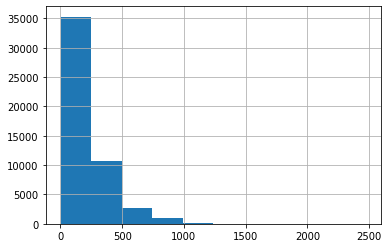

count    50000.000000
mean       230.258240
std        170.663887
min          4.000000
25%        126.000000
50%        172.000000
75%        280.000000
max       2469.000000
dtype: float64

In [14]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()

pd.Series(reviews_len).describe()

In [15]:
len(reviews_int)

50000

In [16]:
# Remove todo review que não tiver, ao menos 1 palavra
reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l > 0]
encoded_labels = [encoded_labels[i] for i, l in enumerate(reviews_len) if l > 0]

In [17]:
len(reviews_int)

50000

Efetua o processo de padding/truncate dos dados. A ideia é que todos os reviews fiquem com o mesmo tamanho, afinal, o objeto da rede neural é que a entrada seja um número fixo de neurônios

In [18]:
# O valor padrão do seq_length é baseado no 3º quartil
def pad_features(reviews_int, seq_length=280):
    # Cria uma matriz zerada - a ideia é que, os espaços vazios sejam preenchidos com 0
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    for i, review in enumerate(reviews_int):
        reviews_len = len(review)

        if reviews_len <= seq_length:
            zeroes = list(np.zeros(seq_length - reviews_len))
            new = zeroes + review
        elif reviews_len > seq_length:
            new = review[0:seq_length]
        
        features[i, :] = np.array(new)
    
    return features

Aqui, a lista de features ficará com 280 de tamanho, para cada review

In [19]:
features = pad_features(reviews_int)
len_feats = len(features)

In [20]:
len(features), len(features[0])

(50000, 280)

Separa em Train, Valid, Test

* 80% para treino
* 10% para valid
* 10% para test

In [21]:
SPLIT_FRAC = 0.8

FACTOR = int(SPLIT_FRAC * len_feats)

train_x = np.array(features[0:FACTOR])
train_y = np.array(encoded_labels[0:FACTOR])

remain_x = np.array(features[FACTOR:])
remain_y = np.array(encoded_labels[FACTOR:])

REMAIN_FACTOR = int(len(remain_x) * 0.5)

valid_x = np.array(remain_x[0:REMAIN_FACTOR])
valid_y = np.array(remain_y[0:REMAIN_FACTOR])

test_x = np.array(remain_x[REMAIN_FACTOR:])
test_y = np.array(remain_y[0:REMAIN_FACTOR:])

Dataloaders e batching

In [22]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data  = TensorDataset(torch.from_numpy(test_x),  torch.from_numpy(test_y))

BATCH_SIZE = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_data,  shuffle=True, batch_size=BATCH_SIZE)

In [23]:
# Exibição de um exemplo de dados

data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: ', sample_x)
print('Sample label size: ', sample_y.size())
print('Sample label: ', sample_y)

Sample input size:  torch.Size([50, 280])
Sample input:  tensor([[     0,      0,      0,  ...,     45,      4,    298],
        [     0,      0,      0,  ...,      1,    207,     35],
        [     0,      0,      0,  ...,     10,  77820,    773],
        ...,
        [     0,      0,      0,  ...,    353,     38,  10689],
        [     0,      0,      0,  ...,     73,     92, 158887],
        [     0,      0,      0,  ...,     51,   6996,    216]])
Sample label size:  torch.Size([50])
Sample label:  tensor([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1])


Define o modelo da classe

In [24]:
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        
        batch_size = x.size(0)

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]

        return sig_out, hidden
    
    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(), 
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Training Network

In [25]:
VOCAB_SIZE = len(vocab_to_int) + 1 # porque o indice inicia em 0 e deve ser iniciado em 1
OUTPUT_SIZE = 1
EMBEDDING_DIM = 400
HIDDEN_DIM = 256
N_LAYERS = 2

model = SentimentLSTM(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS)
model

SentimentLSTM(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [27]:
LR = 0.001
PRINT_EVERY = 1
CLIP = 5

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

epochs = 2
counter = 0

model.train()

for e in range(epochs):
    h = model.init_hidden(BATCH_SIZE)

    for inputs, labels in train_loader:
        counter += 1

        h = tuple([each for each in h])
        model.zero_grad()

        inputs = inputs.type(torch.LongTensor)
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        # Verifica se é para exibir na tela o resultado
        if counter % PRINT_EVERY == 0:
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []

            model.eval()

            for inputs, labels in valid_loader:
                val_h = tuple([each for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = model(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())
            
            model.train()

            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Apos o modelo treinado, executa na base de testes

In [ ]:
test_losses = []
num_correct = 0

h = model.init_hidden(BATCH_SIZE)

model.eval()

for inputs, labels in test_loader:
    



Por fim, efetua a criacao do metodo de predicao, que recebe uma string, com base no modelo salvo